In [1]:
import os
import pandas as pd
import numpy as np
import time

file_path = "2023_09_2024_08_AQI_Weather_dataset.csv"
data = pd.read_csv(file_path, low_memory = False)
sorted_data = data.sort_values(by = ['sitename', 'datacreationdate'])

In [2]:
sorted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114192 entries, 0 to 114191
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datacreationdate  114192 non-null  object 
 1   sitename          114192 non-null  object 
 2   aqi               114192 non-null  float64
 3   so2               114192 non-null  float64
 4   co                114192 non-null  float64
 5   o3                114192 non-null  float64
 6   o3_8hr            114192 non-null  float64
 7   pm10              114192 non-null  float64
 8   pm2.5             114192 non-null  float64
 9   no2               114192 non-null  float64
 10  nox               114192 non-null  float64
 11  no                114192 non-null  float64
 12  co_8hr            114192 non-null  float64
 13  pm2.5_avg         114192 non-null  float64
 14  pm10_avg          114192 non-null  float64
 15  so2_avg           114192 non-null  float64
 16  測站氣壓(hPa)         11

In [3]:
data['datacreationdate'] = pd.to_datetime(data['datacreationdate'])

In [4]:
data.rename(columns={
    '測站氣壓(hPa)': 'station_pressure_hpa',
    '氣溫(℃)': 'temperature_c',
    '相對溼度(%)': 'relative_humidity',
    '風速(m/s)': 'wind_speed_m_s',
    '風向(360degree)': 'wind_direction_deg',
    '降水量(mm)': 'precipitation_mm'
}, inplace=True)

In [5]:
summary = data.describe()
print(summary)

                    datacreationdate            aqi            so2  \
count                         114192  114192.000000  114192.000000   
mean   2024-03-02 00:30:00.000000256      52.573525       1.357898   
min              2023-09-01 01:00:00      -1.000000       0.000000   
25%              2023-12-01 12:45:00      32.000000       0.800000   
50%              2024-03-02 00:30:00      48.000000       1.200000   
75%              2024-06-01 12:15:00      67.000000       1.700000   
max              2024-09-01 00:00:00     169.000000      80.400000   
std                              NaN      26.450290       0.874088   

                  co             o3         o3_8hr           pm10  \
count  114192.000000  114192.000000  114192.000000  114192.000000   
mean        0.366681      28.769889      28.788800      32.425529   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.190000      15.100000      17.000000      18.000000   
50%         0.290000    

In [6]:
class_mapping = {
    'Good': 0,
    'Moderate': 1,
    'Unhealthy for Sensitive Groups': 2,
    'Unhealthy': 3,
    'Very Unhealthy': 4,
    'Hazardous': 5
}

In [7]:
# 定義 AQI 分類函數
def aqi_to_category(aqi):
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 150:
        return 2
    elif aqi <= 200:
        return 3
    elif aqi <= 300:
        return 4
    else:
        return 5

# 應用到數據
data['AQI_level'] = data['aqi'].apply(aqi_to_category)

In [8]:
# 所有特徵列（根據提供數據結構）
all_features = [
    'station_pressure_hpa', 'temperature_c', 'relative_humidity', 'wind_speed_m_s',
    'wind_direction_deg', 'precipitation_mm', 'pm10', 'so2', 'no2', 'nox', 
    'o3', 'co', 'o3_8hr', 'co_8hr', 'pm10_avg', 'so2_avg', 'no'
]

# 24hr -> 1hr

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

def train_and_evaluate_xgboost_regressor_with_classification_metrics(X, y, bins):
    """
    使用 XGBoost 訓練並評估回歸模型，輸出回歸和分類相關指標。
    Args:
        X: 特徵數據。
        y: 目標數據。
        bins: 用於將連續數值劃分為類別的邊界。
    Returns:
        model: 訓練後的 XGBoost 模型。
        results: 回歸和分類相關的評估指標。
    """
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化 XGBoost 回歸模型
    model = xgb.XGBRegressor(
        random_state=42
    )
    model_auroc = xgb.XGBClassifier(
        random_state=42
    )
    # 訓練模型
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 預測目標值
    y_pred = model.predict(X_test)
    
    # 將真實值和預測值劃分為分類標籤
    y_train_labels = np.digitize(y_train, bins) - 1
    y_test_labels = np.digitize(y_test, bins) - 1
    y_pred_labels = np.digitize(y_pred, bins) - 1
    
    model_auroc.fit(X_train, y_train_labels)
    y_prob = model_auroc.predict_proba(X_test)
    
    try:
        if len(y_prob.shape) == 1:  # 一維數據 (二分類特例)
            auroc = roc_auc_score(y_test_labels, y_prob)
        elif len(y_prob.shape) == 2:  # 二維數據
            if y_prob.shape[1] == 2:  # 二分類
                auroc = roc_auc_score(y_test_labels, y_prob[:, 1])
            else:  # 多分類
                auroc = roc_auc_score(y_test_labels, y_prob, multi_class="ovr")
    except Exception as e:
        print(f"Error calculating AUROC: {e}")
        auroc = None
        
    # 計算分類指標
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    f1 = f1_score(y_test_labels, y_pred_labels, average="macro")
    
    # 打印評估指標
    print("Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Training Time: {elapsed_time:.2f} seconds")
    
    # 返回模型和評估結果
    return model, {"accuracy": accuracy, "f1_score": f1, "time": elapsed_time}

    
def train_and_evaluate_xgboost(X, y):
    """
    使用 XGBoost 訓練並評估模型，輸出 Accuracy、F1-score 和 AUROC。
    Args:
        X: 特徵數據。
        y: 目標數據。
    Returns:
        model: 訓練後的 XGBoost 模型。
        results: 評估指標（Accuracy、F1-score、AUROC）。
    """
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 初始化 XGBoost 模型
    model = xgb.XGBClassifier(
        random_state=42
    )
    
    # 訓練模型
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 預測類別
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # 計算評估指標
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    
    # 嘗試計算 AUROC
    try:
        if len(y_prob.shape) == 1:  # 一維數據 (二分類特例)
            auroc = roc_auc_score(y_test, y_prob)
        elif len(y_prob.shape) == 2:  # 二維數據
            if y_prob.shape[1] == 2:  # 二分類
                auroc = roc_auc_score(y_test, y_prob[:, 1])
            else:  # 多分類
                auroc = roc_auc_score(y_test, y_prob, multi_class="ovr")
    except Exception as e:
        print(f"Error calculating AUROC: {e}")
        auroc = None

    # 打印評估指標
    print("Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    if auroc is not None:
        print(f"AUROC: {auroc:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"Training Time: {elapsed_time:.2f} seconds")
    
    # 返回模型和評估結果
    return model, {"accuracy": accuracy, "f1_score": f1, "time": elapsed_time}

def plot_feature_importance(model, feature_names, top_n=10):
    """
    繪製特徵重要性圖。
    Args:
        model: 訓練後的 XGBoost 模型。
        feature_names: 特徵名稱列表。
        top_n: 顯示的特徵數量。
    """
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False).head(top_n)
    
    # 繪圖
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importance")
    plt.gca().invert_yaxis()  # 翻轉 Y 軸，重要特徵在頂部
    plt.show()
    
    return importance_df

Model Performance:
Accuracy: 0.9050
F1-score: 0.8089
AUROC: 0.9852
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     12111
         1.0       0.88      0.90      0.89      9310
         2.0       0.85      0.76      0.80      1298
         3.0       0.96      0.45      0.62        55

    accuracy                           0.91     22774
   macro avg       0.90      0.76      0.81     22774
weighted avg       0.91      0.91      0.90     22774

Training Time: 65.32 seconds


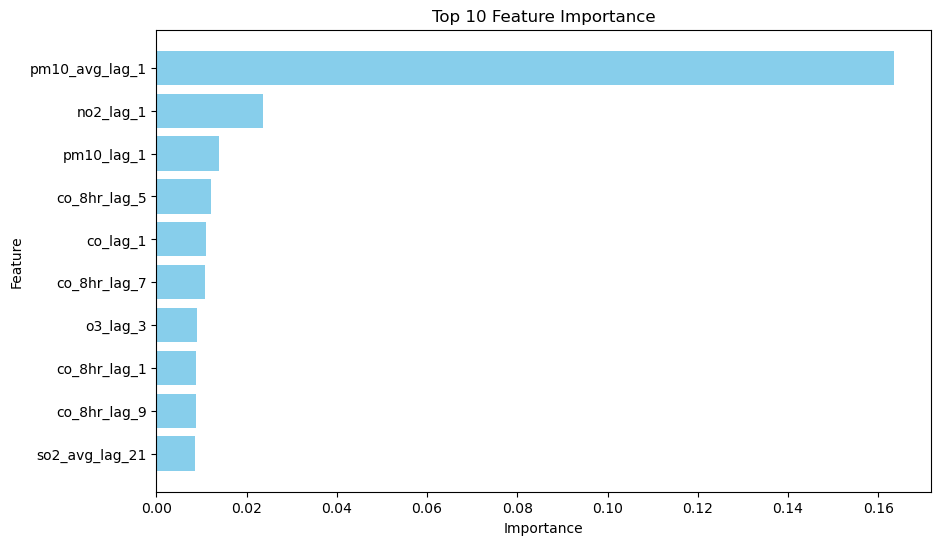

Top 10 Features:
            feature  importance
336  pm10_avg_lag_1    0.163590
192       no2_lag_1    0.023682
144      pm10_lag_1    0.013948
316    co_8hr_lag_5    0.012007
264        co_lag_1    0.011015
318    co_8hr_lag_7    0.010860
242        o3_lag_3    0.008997
312    co_8hr_lag_1    0.008775
320    co_8hr_lag_9    0.008666
380  so2_avg_lag_21    0.008533


In [10]:
# 滯後特徵與目標
lag_features = []
for lag in range(1, 25):
    for feature in all_features:
        lag_features.append(data.groupby('sitename')[feature].shift(lag).rename(f'{feature}_lag_{lag}'))

# 合併滯後特徵
lag_features_df = pd.concat(lag_features, axis=1)
data_with_lags = pd.concat([data.reset_index(drop=True), lag_features_df.reset_index(drop=True)], axis=1)

# 添加目標變數
data_with_lags['AQI_level_next'] = data_with_lags.groupby('sitename')['AQI_level'].shift(-1)
data_with_lags['aqi'] = data_with_lags.groupby('sitename')['aqi'].shift(-1)

# 刪除 NaN
lag_columns_24hr = [f'{feature}_lag_{lag}' for feature in all_features for lag in range(1, 25)]
data_24hr = data_with_lags.dropna(subset=lag_columns_24hr + ['AQI_level_next'])
data_24hr_re = data_with_lags.dropna(subset=lag_columns_24hr + ['aqi'])
X_24hr = data_24hr[lag_columns_24hr]
y_24hr = data_24hr['AQI_level_next']
X_24hr_re = data_24hr_re[lag_columns_24hr]
y_24hr_re = data_24hr_re['aqi']
# 訓練並評估 XGBoost
xgboost_model, metrics = train_and_evaluate_xgboost(X_24hr, y_24hr)

# 繪製特徵重要性圖
top_10_features_24hr = plot_feature_importance(xgboost_model, X_24hr.columns, top_n=10)
print("Top 10 Features:")
print(top_10_features_24hr)

In [11]:
X_24hr

,station_pressure_hpa_lag_1,station_pressure_hpa_lag_2,station_pressure_hpa_lag_3,station_pressure_hpa_lag_4,station_pressure_hpa_lag_5,station_pressure_hpa_lag_6,station_pressure_hpa_lag_7,station_pressure_hpa_lag_8,station_pressure_hpa_lag_9,station_pressure_hpa_lag_10,...,no_lag_15,no_lag_16,no_lag_17,no_lag_18,no_lag_19,no_lag_20,no_lag_21,no_lag_22,no_lag_23,no_lag_24
24,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,1000.7,1000.7,1000.5,...,27.6,27.6,27.7,27.7,27.9,27.9,27.9,27.8,27.7,27.7
25,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,1000.7,1000.7,...,27.6,27.6,27.6,27.7,27.7,27.9,27.9,27.9,27.8,27.7
26,1000.2,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,1000.7,...,27.6,27.6,27.6,27.6,27.7,27.7,27.9,27.9,27.9,27.8
27,999.9,1000.2,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,...,27.5,27.6,27.6,27.6,27.6,27.7,27.7,27.9,27.9,27.9
28,999.9,999.9,1000.2,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,...,27.5,27.5,27.6,27.6,27.6,27.6,27.7,27.7,27.9,27.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114186,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,1008.9,1009.6,1009.7,...,0.2,0.5,0.3,0.0,0.0,0.0,0.4,0.1,0.4,0.9
114187,1008.3,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,1008.9,1009.6,...,0.4,0.2,0.5,0.3,0.0,0.0,0.0,0.4,0.1,0.4
114188,1008.4,1008.3,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,1008.9,...,0.6,0.4,0.2,0.5,0.3,0.0,0.0,0.0,0.4,0.1
114189,1008.9,1008.4,1008.3,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,...,1.2,0.6,0.4,0.2,0.5,0.3,0.0,0.0,0.0,0.4


In [12]:
X_24hr_re

,station_pressure_hpa_lag_1,station_pressure_hpa_lag_2,station_pressure_hpa_lag_3,station_pressure_hpa_lag_4,station_pressure_hpa_lag_5,station_pressure_hpa_lag_6,station_pressure_hpa_lag_7,station_pressure_hpa_lag_8,station_pressure_hpa_lag_9,station_pressure_hpa_lag_10,...,no_lag_15,no_lag_16,no_lag_17,no_lag_18,no_lag_19,no_lag_20,no_lag_21,no_lag_22,no_lag_23,no_lag_24
24,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,1000.7,1000.7,1000.5,...,27.6,27.6,27.7,27.7,27.9,27.9,27.9,27.8,27.7,27.7
25,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,1000.7,1000.7,...,27.6,27.6,27.6,27.7,27.7,27.9,27.9,27.9,27.8,27.7
26,1000.2,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,1000.7,...,27.6,27.6,27.6,27.6,27.7,27.7,27.9,27.9,27.9,27.8
27,999.9,1000.2,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,1001.6,...,27.5,27.6,27.6,27.6,27.6,27.7,27.7,27.9,27.9,27.9
28,999.9,999.9,1000.2,1001.1,1001.6,1002.3,1002.5,1002.6,1002.0,1001.8,...,27.5,27.5,27.6,27.6,27.6,27.6,27.7,27.7,27.9,27.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114186,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,1008.9,1009.6,1009.7,...,0.2,0.5,0.3,0.0,0.0,0.0,0.4,0.1,0.4,0.9
114187,1008.3,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,1008.9,1009.6,...,0.4,0.2,0.5,0.3,0.0,0.0,0.0,0.4,0.1,0.4
114188,1008.4,1008.3,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,1008.9,...,0.6,0.4,0.2,0.5,0.3,0.0,0.0,0.0,0.4,0.1
114189,1008.9,1008.4,1008.3,1008.8,1008.7,1007.9,1007.7,1007.6,1008.1,1008.4,...,1.2,0.6,0.4,0.2,0.5,0.3,0.0,0.0,0.0,0.4


In [13]:
# 定義分箱
bins = [-1, 50, 100, 150, 200, 300, np.inf]

# 調用回歸模型並計算分類相關指標
xgb_model, results = train_and_evaluate_xgboost_regressor_with_classification_metrics(X_24hr_re, y_24hr_re, bins)

# 查看評估結果
print("Evaluation Results:", results)

Model Performance:
Accuracy: 0.8821
F1-Score: 0.5754
AUROC: 0.9839
Training Time: 19.86 seconds
Evaluation Results: {'accuracy': 0.8821023974708, 'f1_score': 0.5753863893512826, 'time': 19.85766577720642}


# 1hr -> 1hr

Model Performance:
Accuracy: 0.8815
F1-score: 0.7503
AUROC: 0.9781
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     12171
         1.0       0.85      0.87      0.86      9310
         2.0       0.78      0.68      0.73      1298
         3.0       0.67      0.40      0.50        55

    accuracy                           0.88     22834
   macro avg       0.80      0.72      0.75     22834
weighted avg       0.88      0.88      0.88     22834

Training Time: 2.33 seconds


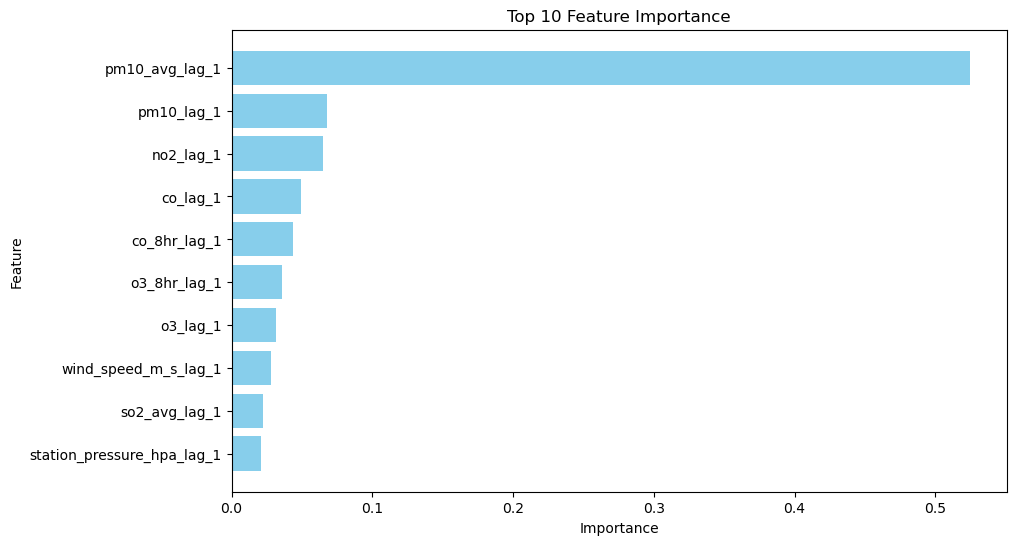

Top 10 Features:
                       feature  importance
14              pm10_avg_lag_1    0.524400
6                   pm10_lag_1    0.067560
8                    no2_lag_1    0.064980
11                    co_lag_1    0.049449
13                co_8hr_lag_1    0.043716
12                o3_8hr_lag_1    0.035841
10                    o3_lag_1    0.031413
3         wind_speed_m_s_lag_1    0.028062
15               so2_avg_lag_1    0.022319
0   station_pressure_hpa_lag_1    0.020774


In [14]:
# 滯後特徵與目標
for feature in all_features:  # all_features 是所有的數據特徵名
    data[f'{feature}_lag_1'] = data.groupby('sitename')[feature].shift(1)

data['AQI_level_next'] = data.groupby('sitename')['AQI_level'].shift(-1)
data['aqi'] = data.groupby('sitename')['aqi'].shift(-1)

# 刪除 NaN
lag_columns_1hr = [f'{feature}_lag_1' for feature in all_features]
data_1hr = data.dropna(subset=lag_columns_1hr + ['AQI_level_next'])
data_1hr = data.dropna(subset=lag_columns_1hr + ['aqi'])

X_1hr = data_1hr[lag_columns_1hr]
y_1hr = data_1hr['AQI_level_next']
X_1hr_re = data_1hr[lag_columns_1hr]
y_1hr_re = data_1hr['aqi']

# 訓練並評估 XGBoost 模型
xgboost_model_1hr, metrics_1hr = train_and_evaluate_xgboost(X_1hr, y_1hr)

# 繪製特徵重要性圖
top_10_features_1hr = plot_feature_importance(xgboost_model_1hr, X_1hr.columns, top_n=10)
print("Top 10 Features:")
print(top_10_features_1hr)

In [15]:
# 定義分箱
bins = [-1, 50, 100, 150, 200, 300, np.inf]

# 調用回歸模型並計算分類相關指標
xgb_model, results = train_and_evaluate_xgboost_regressor_with_classification_metrics(X_1hr_re, y_1hr_re, bins)

Model Performance:
Accuracy: 0.8689
F1-Score: 0.7232
AUROC: 0.9771
Training Time: 0.53 seconds


# 24hr -> 24hr

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import pandas as pd

def train_and_evaluate_xgboost_multioutput(X, y):
    """
    使用 MultiOutputClassifier 封裝 XGBoost 訓練並評估模型，適用於多輸出場景。
    Args:
        X: 特徵數據。
        y: 目標數據（多輸出）。
    Returns:
        model: 訓練後的 MultiOutputClassifier 包裝的 XGBoost 模型。
        metrics: 每個輸出的評估指標。
    """
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化 XGBoost 多輸出模型
    model = MultiOutputClassifier(xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    ))
    
    # 訓練模型
    model.fit(X_train, y_train)
    
    # 評估每個輸出的性能
    metrics = {}
    for i, column in enumerate(y.columns if hasattr(y, 'columns') else range(y.shape[1])):
        y_pred = model.predict(X_test)[:, i]
        y_prob = model.estimators_[i].predict_proba(X_test)
        
        # 計算指標
        accuracy = accuracy_score(y_test[:, i], y_pred)
        f1 = f1_score(y_test[:, i], y_pred, average="macro")
        auroc = roc_auc_score(y_test[:, i], y_prob, multi_class="ovr") if len(y_prob.shape) > 1 else None
        
        # 保存結果
        metrics[f"Target {i+1}"] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "auroc": auroc
        }
        
        # 輸出指標
        print(f"Target {i+1}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-score: {f1:.4f}")
        if auroc is not None:
            print(f"  AUROC: {auroc:.4f}")
        print()
    
    return model, metrics


def plot_feature_importance_multioutput(model, feature_names, top_n=10):
    """
    繪製多輸出模型中每個輸出的特徵重要性圖。
    Args:
        model: MultiOutputClassifier 包裝的 XGBoost 模型。
        feature_names: 特徵名稱列表。
        top_n: 顯示的特徵數量。
    """
    for i, estimator in enumerate(model.estimators_):
        importance = estimator.feature_importances_
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "importance": importance
        }).sort_values(by="importance", ascending=False).head(top_n)
        
        # 繪圖
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Top {top_n} Feature Importance (Target {i+1})")
        plt.gca().invert_yaxis()
        plt.show()

In [17]:
# 滯後特徵
lag_features = []
for lag in range(1, 25):  # 滯後 24 小時
    for feature in all_features:
        lag_features.append(data.groupby('sitename')[feature].shift(lag).rename(f'{feature}_lag_{lag}'))

# 合併滯後特徵
lag_features_df = pd.concat(lag_features, axis=1)
data_with_lags = pd.concat([data.reset_index(drop=True), lag_features_df.reset_index(drop=True)], axis=1)

# 添加目標變數（未來 24 小時）
for lead in range(1, 25):
    data_with_lags[f'AQI_level_future_{lead}'] = data_with_lags.groupby('sitename')['AQI_level'].shift(-lead)

# 刪除 NaN
future_cols = [f'AQI_level_future_{lead}' for lead in range(1, 25)]
lag_columns_future = [f'{feature}_lag_{lag}' for feature in all_features for lag in range(1, 25)]
data_future = data_with_lags.dropna(subset=lag_columns_future + future_cols)

X_future = data_future[lag_columns_future]
y_future = data_future[future_cols]

X_future = X_future.values 
y_future = y_future.values  


In [18]:
# 訓練並評估 XGBoost 多輸出模型
start_time = time.time()
xgboost_model_future, metrics_future = train_and_evaluate_xgboost_multioutput(X_future, y_future)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\

Target 1:
  Accuracy: 0.9027
  F1-score: 0.7821
  AUROC: 0.9850

Target 2:
  Accuracy: 0.8950
  F1-score: 0.7986
  AUROC: 0.9810

Target 3:
  Accuracy: 0.8822
  F1-score: 0.7261
  AUROC: 0.9751

Target 4:
  Accuracy: 0.8761
  F1-score: 0.7154
  AUROC: 0.9738

Target 5:
  Accuracy: 0.8671
  F1-score: 0.6964
  AUROC: 0.9667

Target 6:
  Accuracy: 0.8607
  F1-score: 0.6688
  AUROC: 0.9671

Target 7:
  Accuracy: 0.8543
  F1-score: 0.6694
  AUROC: 0.9611

Target 8:
  Accuracy: 0.8435
  F1-score: 0.6235
  AUROC: 0.9594

Target 9:
  Accuracy: 0.8405
  F1-score: 0.6180
  AUROC: 0.9567

Target 10:
  Accuracy: 0.8368
  F1-score: 0.6477
  AUROC: 0.9529

Target 11:
  Accuracy: 0.8324
  F1-score: 0.6034
  AUROC: 0.9549

Target 12:
  Accuracy: 0.8317
  F1-score: 0.6313
  AUROC: 0.9538

Target 13:
  Accuracy: 0.8309
  F1-score: 0.5863
  AUROC: 0.9519

Target 14:
  Accuracy: 0.8268
  F1-score: 0.6151
  AUROC: 0.9518

Target 15:
  Accuracy: 0.8234
  F1-score: 0.6229
  AUROC: 0.9502

Target 16:
  Accura

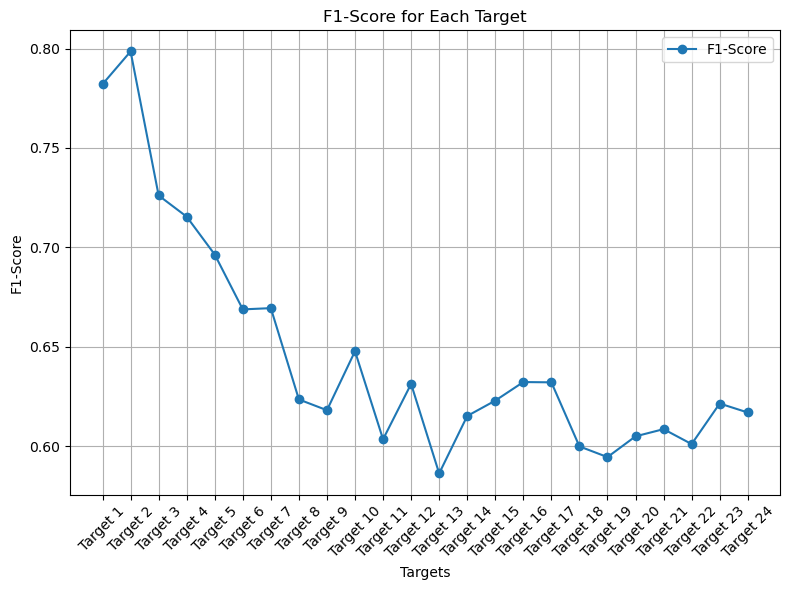

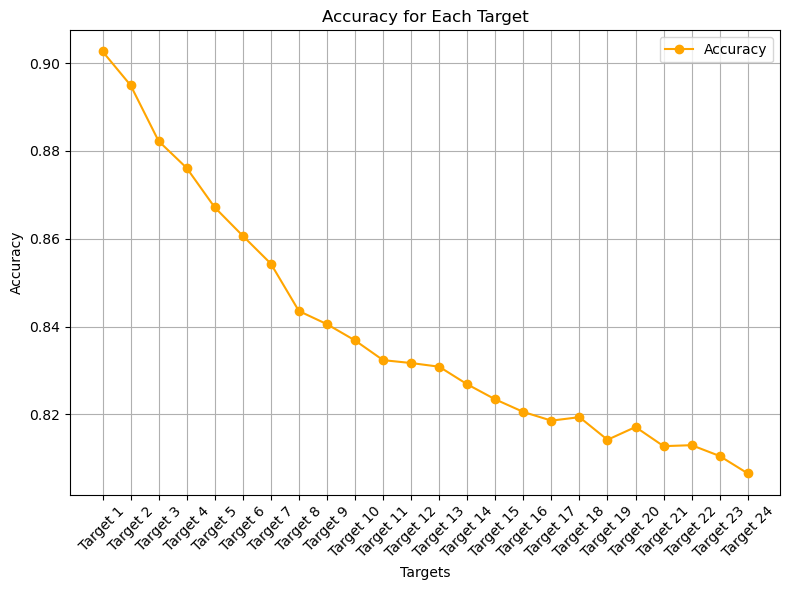

In [19]:
import matplotlib.pyplot as plt

# Extract F1-score and Accuracy for each target from metrics
f1_scores = [metrics_future[f"Target {i+1}"]["f1_score"] for i in range(len(metrics_future))]
accuracies = [metrics_future[f"Target {i+1}"]["accuracy"] for i in range(len(metrics_future))]
targets = [f"Target {i+1}" for i in range(len(metrics_future))]

# Plot F1-score
plt.figure(figsize=(8, 6))
plt.plot(targets, f1_scores, marker='o', linestyle='-', label='F1-Score')
plt.title('F1-Score for Each Target')
plt.xlabel('Targets')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(targets, accuracies, marker='o', linestyle='-', label='Accuracy', color='orange')
plt.title('Accuracy for Each Target')
plt.xlabel('Targets')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
